In [1]:
import pandas as pd
import pystan
from scipy import stats
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQWu3naYNenwRQ6Fvb1Lvc3UgSqvEbzwFr7uOp0TJsHxddWkOXmjPLQpSzWU6hzEq3JvJ28tTzWDm1Q/pub?gid=1459555462&single=true&output=csv',
                   header = 2, names =["Timestamp", "Email", "Name", "Country", "Currency", "Store_Name", "Store_Perception",
                           "Rental_Price",
                           "Apple1_q", "Apple1_p","Apple2_q", "Apple2_p", "Apple3_q", "Apple3_p",
                           "Banana1_q", "Banana1_p","Banana2_q","Banana2_p","Banana3_q", "Banana3_p",
                           "Tomatoes1_q","Tomatoes1_p","Tomatoes2_q","Tomatoes2_p", "Tomatoes3_q", "Tomatoes3_p",
                           "Potato1_q","Potato1_p", "Potato2_q","Potato2_p","Potato3_q","Potato3_p",
                           "Flour1_q","Flour1_p","Flour2_q","Flour2_p", "Flour3_q","Flour3_p",

                           "Rice1_q","Rice1_p","Rice2_q","Rice2_p", "Rice3_q","Rice3_p",

                           "Milk1_q","Milk1_p","Milk2_q","Milk2_p", "Milk3_q", "Milk3_p",
                           "Butter1_q", "Butter1_p", "Butter2_q", "Butter2_p", "Butter3_q", "Butter3_p",
                           "Eggs1_q","Eggs1_p","Eggs2_q", "Eggs2_p","Eggs3_q","Eggs3_p",
                           "Chicken1_q", "Chicken1_p","Chicken2_q","Chicken2_p","Chicken3_q","Chicken3_p",     
                           ]
                   
                   )

First, I drop the name,email, timestamp, columns because they are not necessary for the analysis.  


In [3]:
data = data.drop(labels = ["Name", "Email", "Timestamp", "Store_Name"], axis=1)
data.shape
# data.head()

(50, 64)

## Data Formatting



### Normalizing the prices 

First, I need to bring the prices to the same quantity - 1 kilogram. Some of the quantities have 10,000 number - indicating that this value is invalid. because the price for that qunatity is N/A, the prices will not be affected. Therefore, no need to correct thise quantities. N/A valueds will be dropped. 

Then, I need to convert the prices into one currency - American dollar -  so we can compare the prices of different countries. 

In [4]:
###bringing all the prices to the price per 1 kilo

for i in range(5, 65, 2): #for each of the produce price
    data[data.columns[i]] /= data[data.columns[i-1]]
    # data = data.drop(data.columns[i-1], axis = 1)
# data.head()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [5]:

#dropping the quantities
columns_to_drop = [i for i in range(4, 64, 2)]
data_normalized = data.drop(data.columns[columns_to_drop], axis = 1)


In [6]:

##bringing the prices to the same currency - USD

data_normalized.Currency.unique()

# creating a list of conversion value to dollar for each of the google from response
exchange_rate = []
for cur in data_normalized.Currency:

  if cur == "USD":
    exchange_rate.append(1)

  elif cur == "SEK":
    exchange_rate.append(0.12)
  elif cur ==  'UAH':
    exchange_rate.append(0.036)

  elif cur == "KES":
    exchange_rate.append(0.0091)

  elif cur == "BRL":
    exchange_rate.append(0.17)

  elif cur == "BDT":
    exchange_rate.append(0.012)
data_normalized['Currency_Converter'] = exchange_rate

In [7]:

data_normalized.shape
# data_normalized.head()

(50, 35)

In [8]:
#multiplying the prices by the conversion parameters so that all the prices are in dollars

for i in range(4, 34): #for each of the produce price
    data_normalized[data_normalized.columns[i]] *= data_normalized[data_normalized.columns[34]]

Now the prices are unified across the weight and across the currencies, therefroe, they can be comparable. 

## Countries Formatting

In this section, I am standardizing and replacing the countries value to contain standardized names that later can be classified and put into dictionary. 

In [9]:
#seeing the current countries listed
data_normalized["Country"].unique()

array(['United States', 'Sweden', 'Ukraine', 'USA', 'US',
       'USA (San Francisco)', 'Kenya', 'Brazil',
       'United States of America', 'Dallas, TX, USA',
       'San Francisco, USA', 'San Francisco', 'United States ',
       'Bangladesh', 'San Francisco, United States'], dtype=object)

In [10]:
#replacing with a more unified notation
data_normalized.Country = data_normalized.Country.replace(["United States", "US", 'USA (San Francisco)',
                                                           'United States of America', 'Dallas, TX, USA',
                                                           'San Francisco, USA', 'San Francisco', 'United States ', 'San Francisco, United States'], 
                                                           ["USA", "USA", "USA","USA","USA","USA","USA", "USA", 'USA']
 )
data_normalized.Country.unique()




array(['USA', 'Sweden', 'Ukraine', 'Kenya', 'Brazil', 'Bangladesh'],
      dtype=object)

## Store Type Formating

In this section, I am making the types of the stores (budget, mid-range, luxury) consistent so that the three parameters will have three multipliers. 

In [11]:
#previewing the raw names for the types of stores
print('Initial store classification', data_normalized.Store_Perception.unique())


#replacing with a unified notation
data_normalized.Store_Perception = data_normalized.Store_Perception.replace('Small store in expensive neighborhood (high prices)','Luxury (expensive)' )

print('Formated store classification', data_normalized.Store_Perception.unique())

Initial store classification ['Mid-range' 'Luxury (expensive)' 'Budget (cheap)'
 'Small store in expensive neighborhood (high prices)']
Formated store classification ['Mid-range' 'Luxury (expensive)' 'Budget (cheap)']


## Forming a dictionary 


Here, I first drop the columns that we no longer need and leaving only the prices, store type, and country. Then, I am using the pandas melt function that will help me to create a dictionry of a format, suitable for the stan model. I am leaving only the store type, the country, and the prices as the columns in the pandas object. 


In [12]:
data_normalized.head()


,Country,Currency,Store_Perception,Rental_Price,Apple1_p,Apple2_p,Apple3_p,Banana1_p,Banana2_p,Banana3_p,Tomatoes1_p,Tomatoes2_p,Tomatoes3_p,Potato1_p,Potato2_p,Potato3_p,Flour1_p,Flour2_p,Flour3_p,Rice1_p,Rice2_p,Rice3_p,Milk1_p,Milk2_p,Milk3_p,Butter1_p,Butter2_p,Butter3_p,Eggs1_p,Eggs2_p,Eggs3_p,Chicken1_p,Chicken2_p,Chicken3_p,Currency_Converter
0,USA,USD,Mid-range,2996,3.445996,2.637766,2.196914,1.967033,2.083333,NaN,7.026432,2.841410,9.966667,1.141975,7.338235,5.867647,1.626984,2.076923,12.076923,5.791667,7.047059,3.615385,1.158730,1.052910,2.389222,5.325581,8.200000,14.297297,0.140833,0.132778,0.332500,13.193833,7.574956,4.680265,1.00
1,USA,USD,Luxury (expensive),3360,5.484581,6.585903,8.788546,1.079295,3.281938,4.383260,4.383260,3.942731,6.585903,2.180617,2.841410,3.281938,3.522928,4.316578,3.214286,4.955899,4.340659,8.223529,1.527704,2.500000,5.252632,9.977778,18.644444,19.960000,0.724167,0.499167,0.482500,10.991189,13.193833,15.396476,1.00
2,USA,USD,Budget (cheap),4000,4.383260,2.621145,2.180617,1.299559,1.519824,1.740088,2.841410,3.942731,3.722467,0.664444,1.740088,2.180617,2.194046,1.185022,0.964758,4.950386,3.519824,8.892857,0.915567,2.151079,0.525066,8.127753,9.889868,10.991189,0.332500,0.374167,0.249167,13.193833,4.845543,9.889868,1.00
3,USA,USD,Luxury (expensive),4000,9.000000,4.760000,NaN,4.125874,NaN,NaN,4.166667,35.235294,NaN,17.500000,21.071429,NaN,3.960352,8.009631,NaN,5.501654,NaN,NaN,5.803383,2.640212,5.422705,39.603524,16.233062,26.387665,0.499167,0.457500,NaN,47.000000,NaN,NaN,1.00
4,Sweden,SEK,Budget (cheap),6887,3.480000,3.600000,2.400000,3.000000,3.240000,3.360000,3.840000,7.680000,6.480000,1.440000,1.440000,1.320000,0.720000,0.840000,0.960000,3.960000,2.820000,5.640000,1.560000,1.200000,1.040000,9.360000,9.360000,11.280000,0.360000,0.300000,0.350000,12.972973,16.735135,11.666667,0.12


In [13]:

#dropping the irrelevant columns from the df
final_data =data_normalized.drop(labels = ["Currency", "Currency_Converter"], axis=1)


#getting the value_vars parameter for the melt function to melt them into one column
value_var = ['Apple1_p', 'Apple2_p', 'Apple3_p',
         'Banana1_p', 'Banana2_p', 'Banana3_p',
         'Tomatoes1_p', 'Tomatoes2_p', 'Tomatoes3_p',
         'Potato1_p', 'Potato2_p', 'Potato3_p',
         'Flour1_p', 'Flour2_p', 'Flour3_p',
         'Rice1_p', 'Rice2_p', 'Rice3_p',
         'Milk1_p', 'Milk2_p', 'Milk3_p',
         'Butter1_p', 'Butter2_p', 'Butter3_p',
         'Eggs1_p', 'Eggs2_p', 'Eggs3_p',
         'Chicken1_p', 'Chicken2_p', 'Chicken3_p']


#melting the df on the price
final_data_input = pd.melt(final_data, id_vars=['Country', 'Store_Perception'],
                     value_vars=value_var,
                     value_name = 'Price', var_name = 'Product')

final_data_input.shape

(1500, 4)

Now I need to change the values of the product to contain 10 keywords for each of the product type. 

In [14]:
#stripping the endings of the Product column so it only contains 10 types of vegetables
final_data_input["Product"] = final_data_input["Product"].apply(lambda x: re.sub(r'[0-9]{1}_p', '',x))



In [15]:

#saving the names of the countries, products, and countries to plot the distributions later
products_names = final_data_input.Product.unique()
country_names = final_data_input.Country.unique()
store_names = final_data_input.Store_Perception.unique()

In [16]:
#replacing the strings of stores and countries with the indexes to insert into Stan model
final_data_input.Store_Perception = final_data_input.Store_Perception.replace(
    ['Mid-range', 'Luxury (expensive)', 'Budget (cheap)'],
    [1,2,3])


#replacing the countries
final_data_input.Country = final_data_input.Country.replace(
    ['USA', 'Sweden', 'Ukraine', 'Kenya', 'Brazil', 'Bangladesh'],
    [1,2,3,4,5,6])


#replacing the products
final_data_input.Product = final_data_input.Product.replace(
    ['Apple', 'Banana', 'Tomatoes', 'Potato', 'Flour', 'Rice', 'Milk',
       'Butter', 'Eggs', 'Chicken'],
    [1,2,3,4,5,6,7,8,9,10])


In [17]:
print(final_data_input.head())
final_data_input = final_data_input.dropna()
final_data_input.shape

   Country  Store_Perception  Product     Price
0        1                 1        1  3.445996
1        1                 2        1  5.484581
2        1                 3        1  4.383260
3        1                 2        1  9.000000
4        2                 3        1  3.480000


(1293, 4)

In [18]:
model_data = {
    
    #Data values
    "prices_N" : final_data_input.shape[0], #prices observations, 30*(number of forms)
    'prices' : final_data_input.Price.values, #prices for each of teh observation


    'store_N': len(final_data_input.Store_Perception.unique()), # types of stores - 3
    "store_types" : final_data_input.Store_Perception.values, # vals 1-3 to indicate the store pricing

    'country_N': len(final_data_input.Country.unique()), # countries in analysis - 6
    "countries" : final_data_input.Country.values, #cals 1-6 to indicate different countries 


    'products_N': len(final_data_input.Product.unique()), #products observed  - 10  
    'products': final_data_input.Product.values # vals 1-10 for each product type

}
# type(list(model_data['countries']))
# print(model_data['countries'])
# print((model_data['prices_N']))
# final_data_input.Country.unique()

#Building the model

In this seciton, I will build the stan models. Then, I will visualize the results of the stan model with the predicted prices, country, and store type multipliers distribution, as we have previously conducted with the election votes. This will help to jusge on whether the predictions seem plausible.

In [19]:
stan_code = """

data {
  int<lower=1> prices_N;                  // number of observed prices
  real<lower =0> prices[prices_N];         //list of prices


  int<lower=1> store_N;                 // number of different store types
  int<lower =1> store_types[prices_N];            // list of store types


  int<lower=1> country_N;               // number of countries 
  int<lower = 1> countries[prices_N];  // list of countries 


  int<lower = 1> products_N;            // number of different products presented
  int<lower = 1> products[prices_N];  // list of different products

}


parameters {

  // 3 multipliers to input into likelihood function
  real<lower = 0> base_price[products_N]; // 10 different base prices
  real<lower=0> country_multiplier[country_N]; // 6 different multipliers
  real<lower = 0> store_multiplier[store_N]; // 3 multipliers



// unknown parameters

real<lower = 0> sigma;
real<lower=0> lambda;
}

model {

//Hyperparameters priors

sigma ~ gamma(1,1); //uninformed prior about the uncertainty of the N distribution
lambda ~ gamma(1, 0.2); //hyperparameter for the exponential likelihood function


// Priors

base_price ~ exponential(lambda);
country_multiplier ~ lognormal(0,1);
store_multiplier ~ lognormal(0,1);


//Likelihood

for (datum in 1:prices_N) {
    prices[datum] ~ normal(base_price[products[datum]]*country_multiplier[countries[datum]]*store_multiplier[store_types[datum]], sigma);


}


}
"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a522a2221284f0a635ed76517be7843f NOW.


In [20]:
results = stan_model.sampling(data=model_data)
print(results)


Inference for Stan model: anon_model_a522a2221284f0a635ed76517be7843f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]           2.88    0.11   2.36   0.56   1.39   2.22    3.6   9.49    430   1.01
base_price[2]           1.52    0.06   1.27   0.29   0.72   1.15   1.89   4.98    434    1.0
base_price[3]           3.59    0.14   2.92   0.72   1.74   2.76    4.5  11.72    428   1.01
base_price[4]           1.88    0.07   1.56   0.37    0.9   1.44   2.35   6.16    439   1.01
base_price[5]           1.66    0.07   1.37   0.32   0.79   1.29   2.07    5.5    438   1.01
base_price[6]           2.99    0.12   2.43    0.6   1.45   2.31   3.72   9.86    432   1.01
base_price[7]           1.17    0.05   0.98   0.22   0.55   0.89   1.46   3.87    449   1.01
base_price[8]           8.09    0.32   6.56   1.61   3.91   6.23  1

In [21]:
samples = results.extract()

## Distribution of predicted base prices

The base price looks okay, with butter and chicken having the highest prices and highest uncertainty. By looking at the data, this trends looks consistent. This graph, however, does not reproduce the real prices because prices will be change by the country and store type multipliers, the distribution for which are shown below.

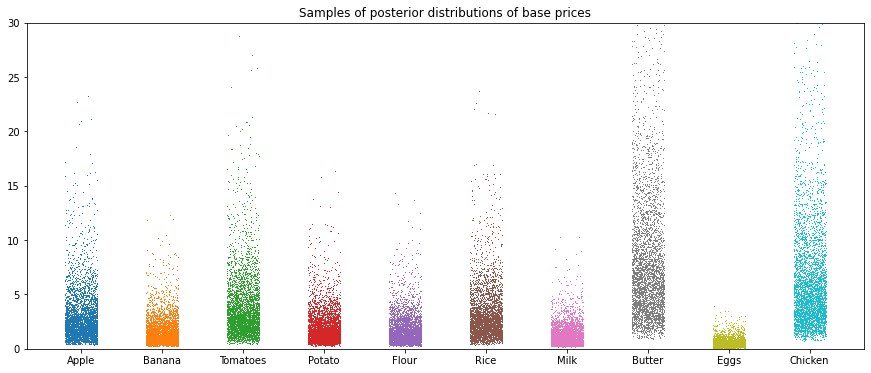

In [22]:
plt.figure(figsize=(15,6))

for i in range(model_data['products_N']): #for each of the product
    plt.plot(stats.uniform.rvs(loc=i, scale=0.4, size = 4000),
             samples['base_price'][:,i], ',', alpha=2)
    
# plt.plot(range(1, len(final_data.Product.unique()) + 1),
#          samples['base_price'].mean(axis=0), marker='.',
#          linewidth=0,color="black", alpha=0.8, markersize=12)

plt.title('Samples of posterior distributions of base prices')
plt.xticks(range(1,11), (products_names))
plt.ylim(0, 30)
plt.show()

## Distribution of country multiplier

The multipliers are mostly above or very close to 1. For the more expensive and developed countries, the multiplier range is higher (USA and Sweden) that will make the prices more expensive. For Kenya, Brazil, and Bangladesh, the multipliers are lower. This distribution seems relevant and error-free

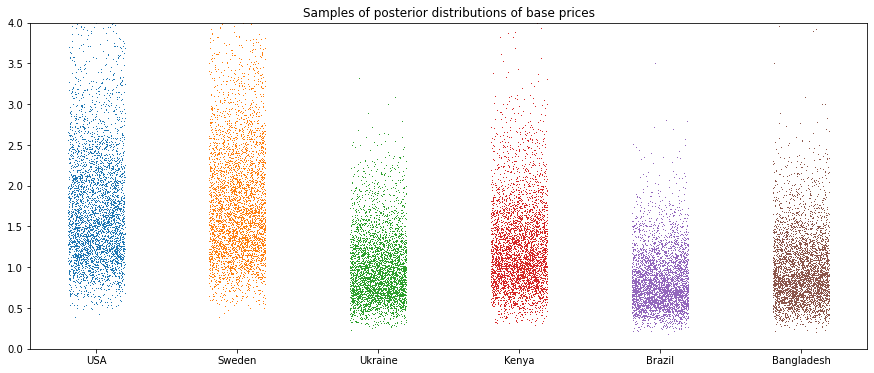

In [23]:
plt.figure(figsize=(15,6))

for i in range(model_data['country_N']): #for each of the country
    plt.plot(stats.uniform.rvs(loc=i, scale=0.4, size = 4000),
             samples['country_multiplier'][:,i], ',', alpha=2)


plt.title('Samples of posterior distributions of base prices')
plt.xticks(range(1,7), (country_names))
plt.ylim(0, 4)
plt.show()

##Distribution of Store Type Multiplier

The budget stores have the lowest values. They are slightly below 1, reducing the price of the products. The mid range and the expensive stores have higher values, with mid range more concentrated in the lower part of the distribution. They are very similar. This might be because of the students' perception of the stores and where in one location, the store is considered mid-range, but in the other - as luxury, but they will have similar prices or their correlation

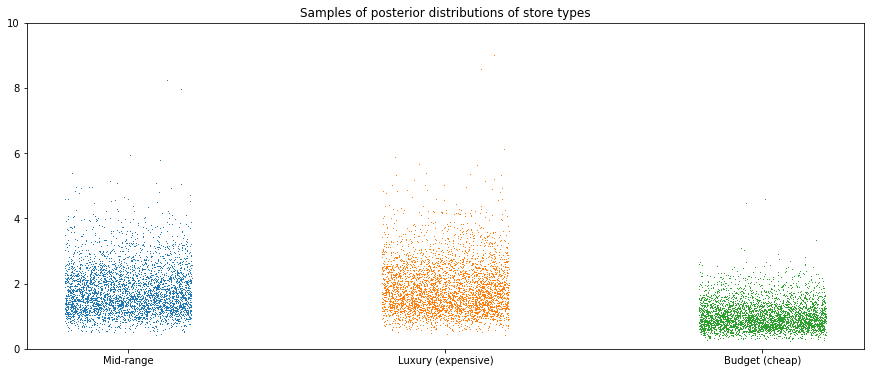

In [24]:
plt.figure(figsize=(15,6))

for i in range(model_data['store_N']): #for each of the store type
    plt.plot(stats.uniform.rvs(loc=i, scale=0.4, size = 4000),
             samples['country_multiplier'][:,i], ',', alpha=2)


plt.title('Samples of posterior distributions of store types')
plt.xticks(range(1,4), (store_names))
plt.ylim(0, 10)
plt.show()

#Rental Prices and Country Multipliers' Correlation

In this section, I will extract the Correlation Coefficient (R-squared) for the rental prices and the country multiplier. 

First, I cleaned the rental data to contain only numbers. I converted all the values that were in dollars to current currency and looked through the numbers for sanity check. 


Then, I saved the data in the correct format. 

Last, I calculated $R^2$ and outputted the correlation plot. 

In [25]:
### CLEANING THE RENTAL DATA

#country multipliers data
countries_multipliers = samples['country_multiplier'].mean(axis=0)



#creating df containing country and the rental price
rental_df_data = [final_data.Rental_Price, final_data.Country, data_normalized.Currency_Converter]
rental_df_headers = ['Rental_prices', 'Country', "Currency_Converter"]
rental_price = pd.concat(rental_df_data, axis =1, keys = rental_df_headers)


#manually cleaning the rental prices

rental_price.loc[8,'Rental_prices'] = 2595
rental_price.loc[9,'Rental_prices'] = 1695
rental_price.loc[10,'Rental_prices'] = 28000
rental_price.loc[11,'Rental_prices'] = 42000
rental_price.loc[44,'Rental_prices'] = 4000
rental_price.loc[45,'Rental_prices'] = 3000
rental_price.loc[21,'Rental_prices'] = 1934
rental_price.loc[38,'Rental_prices'] = 2595	
rental_price.loc[39,'Rental_prices'] = 2595	

#converting the prices to dollars

rental_price.Rental_prices= pd.to_numeric(rental_price.Rental_prices, downcast="float")
rental_price.Rental_prices *=rental_price.Currency_Converter




  


In [26]:
## RENTAL DATA IN THE RIGHT FORMAT - MEANS PER COUNTRY IN DOLLARS

USA = []
Kenya = [455]
Brazil = []
Bangladesh = [48, 36]
Ukraine = []
Sweden = [826.44, 826.44	]



#get the prices based on a country
for i in range (50):
  #sort out US rental prices
  if rental_price.loc[i,'Country'] == 'USA':
    USA.append(rental_price.loc[i,'Rental_prices'])	

  elif rental_price.loc[i,'Country'] == 'Brazil':
    Brazil.append(rental_price.loc[i,'Rental_prices'])	


  elif rental_price.loc[i,'Country'] == 'Ukraine':
    Ukraine.append(rental_price.loc[i,'Rental_prices'])	




#getting the rental prices means for each country
USA_mean = np.mean(USA)
Kenya_mean = 455
Brazil_mean = np.mean(Brazil)
Bangladesh_mean = np.mean(Bangladesh)
Sweden_mean = 826.44
Ukraine_mean = np.mean(Ukraine)


#putting the mean values into 1 list
means = [USA_mean, Sweden_mean, Ukraine_mean, Kenya_mean, Brazil_mean, Bangladesh_mean]





0.4911380003665486


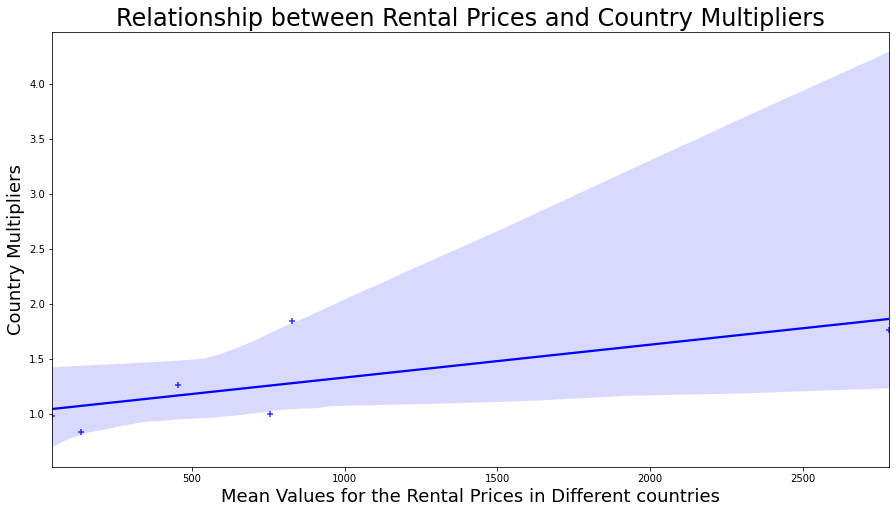

In [27]:
##CALCULATING THE CORRELATION

correlation_matrix = np.corrcoef(means, countries_multipliers)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2 

print(r_squared)


# regression plot using seaborn
fig = plt.figure(figsize=(15, 8))
sns.regplot(x=means, y=countries_multipliers, color='blue', marker='+')

# Legend, title and labels.
plt.title('Relationship between Rental Prices and Country Multipliers', size=24)
plt.xlabel('Mean Values for the Rental Prices in Different countries', size=18)
plt.ylabel('Country Multipliers', size=18);
